https://keras.io/guides/transfer_learning/

An end-to-end example: fine-tuning an image classification model on a cats vs. dogs

dataset

To solidify these concepts, let's walk you through a concrete end-to-end transfer learning & fine-tuning example. We will load the Xception model, pre-trained on ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.

In [1]:
!pip install tf-nightly-gpu

     |████████████████████████████████| 322.4MB 47kB/s 
     |████████████████████████████████| 460kB 35.3MB/s 
     |████████████████████████████████| 3.0MB 35.9MB/s 


In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.3.0-dev20200625'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteIJBP5H/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: -2
Number of validation samples: -2
Number of test samples: -2


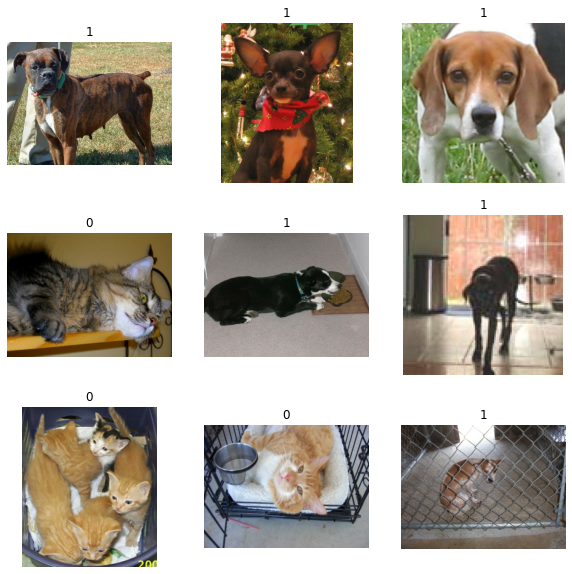

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [7]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


In [8]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


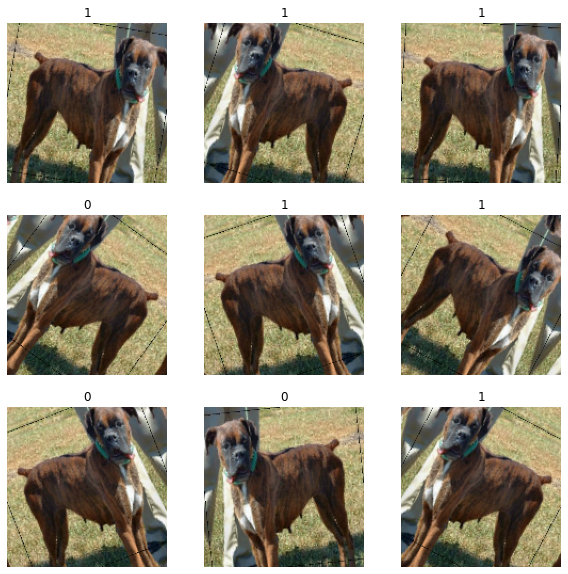

In [10]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [11]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


83689472/83683744 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_______________________________________________________

Train the top layer

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Epoch 1/20
291/291 [==============================] - 64s 219ms/step - loss: 0.1733 - binary_accuracy: 0.9240 - val_loss: 0.0884 - val_binary_accuracy: 0.9669
Epoch 2/20
291/291 [==============================] - 57s 195ms/step - loss: 0.1217 - binary_accuracy: 0.9498 - val_loss: 0.0808 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 57s 195ms/step - loss: 0.1128 - binary_accuracy: 0.9525 - val_loss: 0.0785 - val_binary_accuracy: 0.9708
Epoch 4/20
291/291 [==============================] - 56s 193ms/step - loss: 0.1084 - binary_accuracy: 0.9553 - val_loss: 0.0815 - val_binary_accuracy: 0.9712
Epoch 5/20
291/291 [==============================] - 56s 192ms/step - loss: 0.1068 - binary_accuracy: 0.9544 - val_loss: 0.0758 - val_binary_accuracy: 0.9721
Epoch 6/20
291/291 [==============================] - 56s 192ms/step - loss: 0.0987 - binary_accuracy: 0.9610 - val_loss: 0.0770 - val_binary_accuracy: 0.9716
Epoch 7/20
291/291 [==========================

Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

In [13]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

291/291 [==============================] - 186s 640ms/step - loss: 0.0805 - binary_accuracy: 0.9695 - val_loss: 0.0516 - val_binary_accuracy: 0.9781
Epoch 2/10
291/291 [==============================] - 184s 633ms/step - loss: 0.0590 - binary_accuracy: 0.9771 - val_loss: 0.0464 - val_binary_accuracy: 0.9815
Epoch 3/10
291/291 [==============================] - 184s 633ms/step - loss: 0.0403 - binary_accuracy: 0.9842 - val_loss: 0.0478 - val_binary_accuracy: 0.9811
Epoch 4/10
291/291 [==============================] - 184s 634ms/step - loss: 0.0407 - binary_accuracy: 0.9854 - val_loss: 0.0435 - val_binary_accuracy: 0.9811
Epoch 5/10
291/291 [==============================] - 184s 633ms/step - loss: 0.0311 - binary_accuracy: 0.9890 - val_loss: 0.0403 - val_binary_accuracy: 0.9811
Epoch 6/10
291/291 [==============================] - 185s 634ms/step - loss: 0.0239 - binary_accuracy: 0.9904 - val_loss: 0.0383 - val_binary_accuracy: 0.9841
Epoch 7/10
291/291 [==============================]

We have improved accuracy

In [14]:
#save your model in the SavedModel format
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)
# Converting a SavedModel to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

#reduce the size of a floating point model by quantizing the weights to float16
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

open("model_tl.tflite", "wb").write(tflite_model)
open("model_quant_tl.tflite", "wb").write(tflite_quant_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


41679920

In [17]:
ls

model_quant_tl.tflite  model_tl.tflite  sample_data/  saved_model/
